# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [570]:
import json
import numpy as np

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -copyFromLocal data .

In [6]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-05 20:16 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-05 20:16 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-05 20:16 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-05 20:16 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-05 20:16 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-05 20:16 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-05 20:16 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-05 20:16 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-05 20:16 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [5]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [9]:
%%time
ratings.take(5)

CPU times: user 4.45 ms, sys: 5.23 ms, total: 9.67 ms
Wall time: 3.03 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [10]:
ratings.getNumPartitions()

5

In [7]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [16]:
ratings.count()

25000095

Количество пользователей

In [17]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 22.2 ms, sys: 5.81 ms, total: 28 ms
Wall time: 1min 39s


162541

Сохраним датасет в память

In [12]:
ratings = ratings.persist()

Количество фильмов

In [21]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 44.8 ms, sys: 31.5 ms, total: 76.3 ms
Wall time: 6min 56s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [8]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [9]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [24]:
movies.take(5)

[(1, ['1', 'Toy Story (1995)']),
 (2, ['2', 'Jumanji (1995)']),
 (3, ['3', 'Grumpier Old Men (1995)']),
 (4, ['4', 'Waiting to Exhale (1995)']),
 (5, ['5', 'Father of the Bride Part II (1995)'])]

In [15]:
movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

CPU times: user 9.8 ms, sys: 1.35 ms, total: 11.1 ms
Wall time: 60.5 ms


In [25]:
movie_avg_rating.take(5)

[(32770, 3.5727272727272728),
 (5, 3.0584343520573674),
 (196615, 3.5),
 (131080, 3.0),
 (10, 3.42145763311516)]

In [17]:
%%time
movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

CPU times: user 55.6 ms, sys: 14.3 ms, total: 70 ms
Wall time: 3min 11s


[(180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)'])),
 (175077, (5.0, ['175077', 'Fatal Call (2012)'])),
 (116606, (5.0, ['116606', 'Dark Hearts (2014)']))]

In [40]:
%%time
movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .map(lambda a: (a[1][0], a[1][1][1])) \
    .take(10)

CPU times: user 42.1 ms, sys: 17 ms, total: 59.2 ms
Wall time: 3.17 s


[(5.0, 'I Am JFK Jr. (2016)'),
 (5.0, '"Goodbye'),
 (5.0, "Tarzan's Fight for Life (1958)"),
 (5.0, 'Loaded (2014)'),
 (5.0, 'Private Duty Nurses (1971)'),
 (5.0, 'Judy (2014)'),
 (5.0, 'You Cast A Spell On Me (2015)'),
 (5.0, 'Black Oak Conspiracy (1977)'),
 (5.0, 'Elf Bowling the Movie (2007)'),
 (5.0, 'She Who Must Burn')]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [20]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [21]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-05 20:28 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58904 2021-02-05 20:28 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112506 2021-02-05 20:28 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131453 2021-02-05 20:28 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114337 2021-02-05 20:28 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133628 2021-02-05 20:28 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117767 2021-02-05 20:28 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     142908 2021-02-05 20:28 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132351 2021-02-05 20:28 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167661 2021-02-05 20:28 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [16]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [27]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [28]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

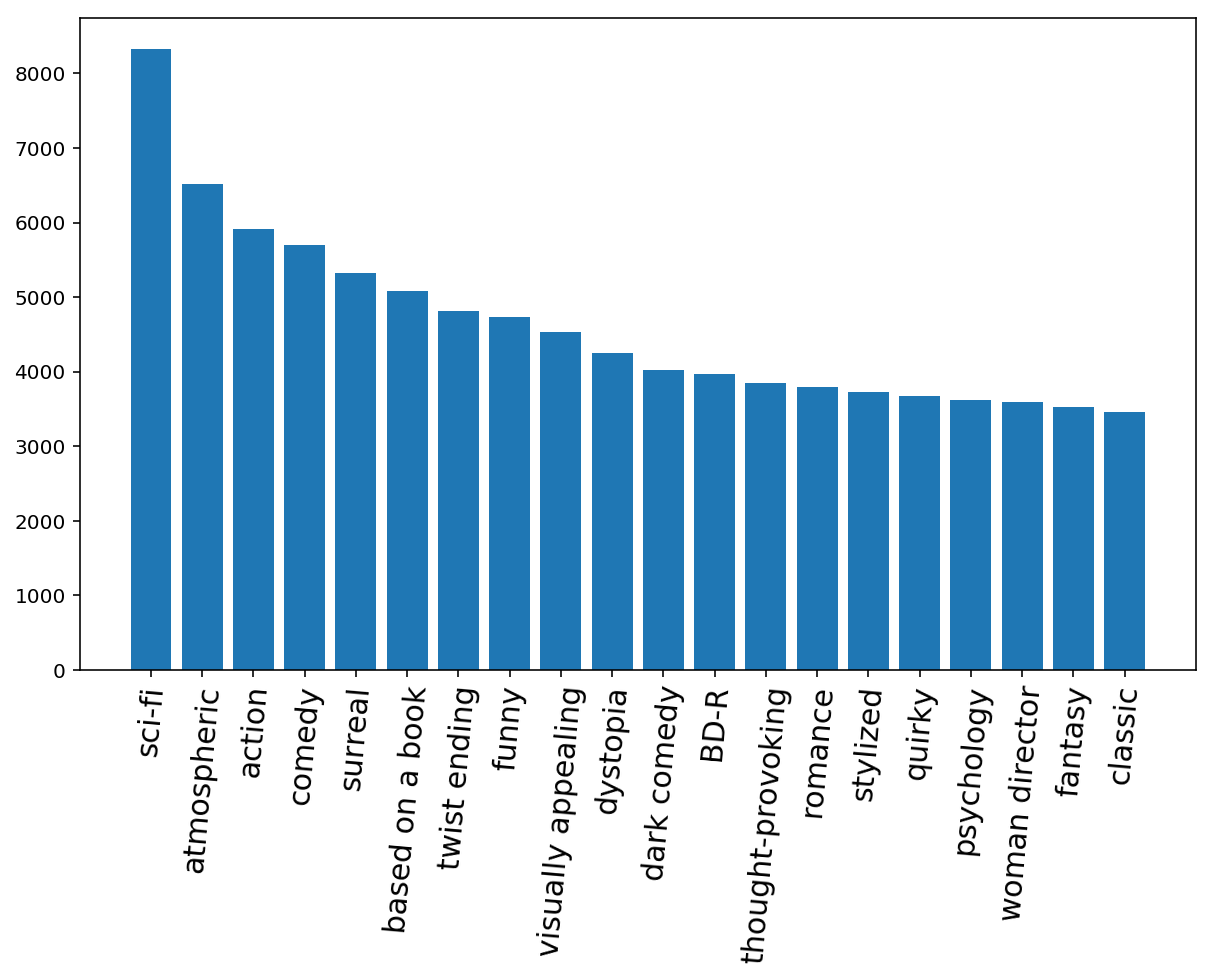

In [29]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

# Homework

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [509]:
movieId_count = sc.textFile(RATINGS_PATH) \
                .map(lambda s: s.split(',')) \
                .filter(lambda arr: arr[0].isdigit()) \
                .filter(lambda arr: arr[1].isdigit()) \
                .map(lambda x: (int(x[1]), 1)) \
                .reduceByKey(lambda a, b: a + b)

movieId_count.take(5)

[(32770, 165), (5, 11714), (196615, 1), (131080, 97), (10, 28265)]

In [513]:
movieId_title = sc.textFile(MOVIES_PATH) \
                .map(lambda s: s.split(',')) \
                .filter(lambda arr: arr[0].isdigit()) \
                .map(lambda x: (int(x[0]), x[1]))

movieId_title.take(5)

[(1, 'Toy Story (1995)'),
 (2, 'Jumanji (1995)'),
 (3, 'Grumpier Old Men (1995)'),
 (4, 'Waiting to Exhale (1995)'),
 (5, 'Father of the Bride Part II (1995)')]

In [519]:
top10_rated = movieId_title \
              .join(movieId_count) \
              .map(lambda x: x[1]) \
              .sortBy(lambda x: x[1], ascending=False) \
              .collect()

top10_rated[:10]

[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [533]:
movieId_5_count = sc.textFile(RATINGS_PATH) \
                  .map(lambda s: s.split(',')) \
                  .filter(lambda arr: arr[0].isdigit()) \
                  .map(lambda x: (int(x[1]), (float(x[2]), 1))) \
                  .filter(lambda x: x[1][0] == 5.0) \
                  .mapValues(lambda x: x[1]) \
                  .reduceByKey(lambda a, b: a + b)
                    
#                   .map(lambda x: (int(x[1]), 1)) \
#                   .reduceByKey(lambda a, b: a + b)

movieId_5_count.take(5)

[(122880, 3), (32770, 10), (8195, 136), (5, 840), (131080, 8)]

In [534]:
movieId_title = sc.textFile(MOVIES_PATH) \
                .map(lambda s: s.split(',')) \
                .filter(lambda arr: arr[0].isdigit()) \
                .map(lambda x: (int(x[0]), x[1]))

movieId_title.take(5)

[(1, 'Toy Story (1995)'),
 (2, 'Jumanji (1995)'),
 (3, 'Grumpier Old Men (1995)'),
 (4, 'Waiting to Exhale (1995)'),
 (5, 'Father of the Bride Part II (1995)')]

In [539]:
movie_5_count = movieId_5_count \
                .join(movieId_title) \
                .map(lambda x: (x[1][1], x[1][0])) \
                .sortBy(lambda x: x[1], ascending=False) \
                .collect()

movie_5_count[:10]

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [545]:
movie_avg_rating = sc.textFile(RATINGS_PATH) \
                   .map(lambda s: s.split(',')) \
                   .filter(lambda arr: arr[0].isdigit()) \
                   .filter(lambda arr: arr[1].isdigit()) \
                   .map(lambda x: (int(x[1]), (float(x[2]), 1))) \
                   .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
                   .mapValues(lambda x: x[0] / x[1])

movie_avg_rating.take(5)

[(32770, 3.5727272727272728),
 (5, 3.0584343520573674),
 (196615, 3.5),
 (131080, 3.0),
 (10, 3.42145763311516)]

In [546]:
ratings_distr = movie_avg_rating.map(lambda a: a[1]).collect()

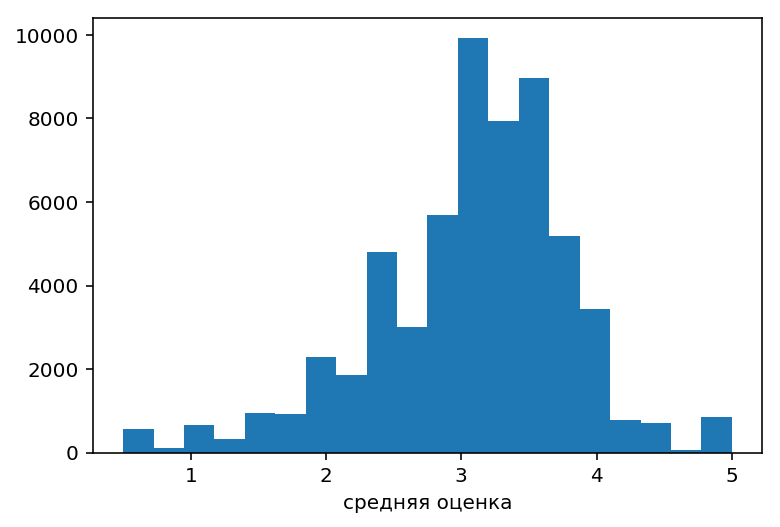

In [552]:
plt.hist(ratings_distr, bins=20)
plt.xlabel("средняя оценка")
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [551]:
movie_rates_num = sc.textFile(RATINGS_PATH) \
                  .map(lambda s: s.split(',')) \
                  .filter(lambda arr: arr[0].isdigit()) \
                  .filter(lambda arr: arr[1].isdigit()) \
                  .map(lambda x: (int(x[1]), 1)) \
                  .reduceByKey(lambda a, b: (a + b)) 

movie_rates_num.take(5)

[(32770, 165), (5, 11714), (196615, 1), (131080, 97), (10, 28265)]

In [553]:
rates_num_distr = movie_rates_num.map(lambda a: a[1]).collect()

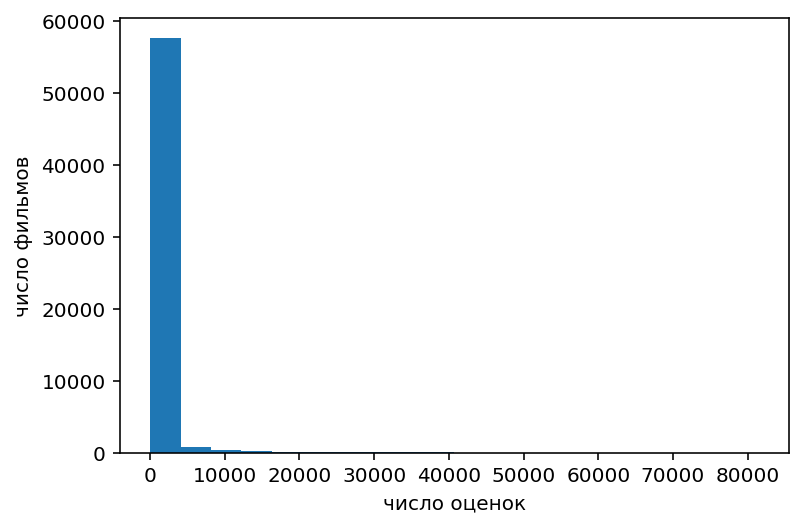

In [554]:
plt.hist(rates_num_distr, bins=20)
plt.ylabel("число фильмов")
plt.xlabel("число оценок")
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [ ]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

In [79]:
genres = sc.textFile(MOVIES_PATH)

In [73]:
genres.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [ ]:
a = [0, 1, 2, 3, 4, 5]
a[0, ]

In [566]:
genres_count = sc.textFile(MOVIES_PATH) \
               .map(lambda s: s.split(',')) \
               .filter(lambda arr: arr[0].isdigit()) \
               .filter(lambda arr: len(arr) == 3) \
               .map(lambda x: (int(x[0]), x[2].split('|'))) \
               .flatMapValues(lambda x: x) \
               .map(lambda x: (x[1], 1)) \
               .reduceByKey(lambda a, b: a + b) \
               .sortBy(lambda x: x[1], ascending=False)

genres_count.take(5)

[('Drama', 22111),
 ('Comedy', 14831),
 ('Thriller', 7645),
 ('Romance', 6718),
 ('Action', 6678)]

In [564]:
gc = genres_count.collect()

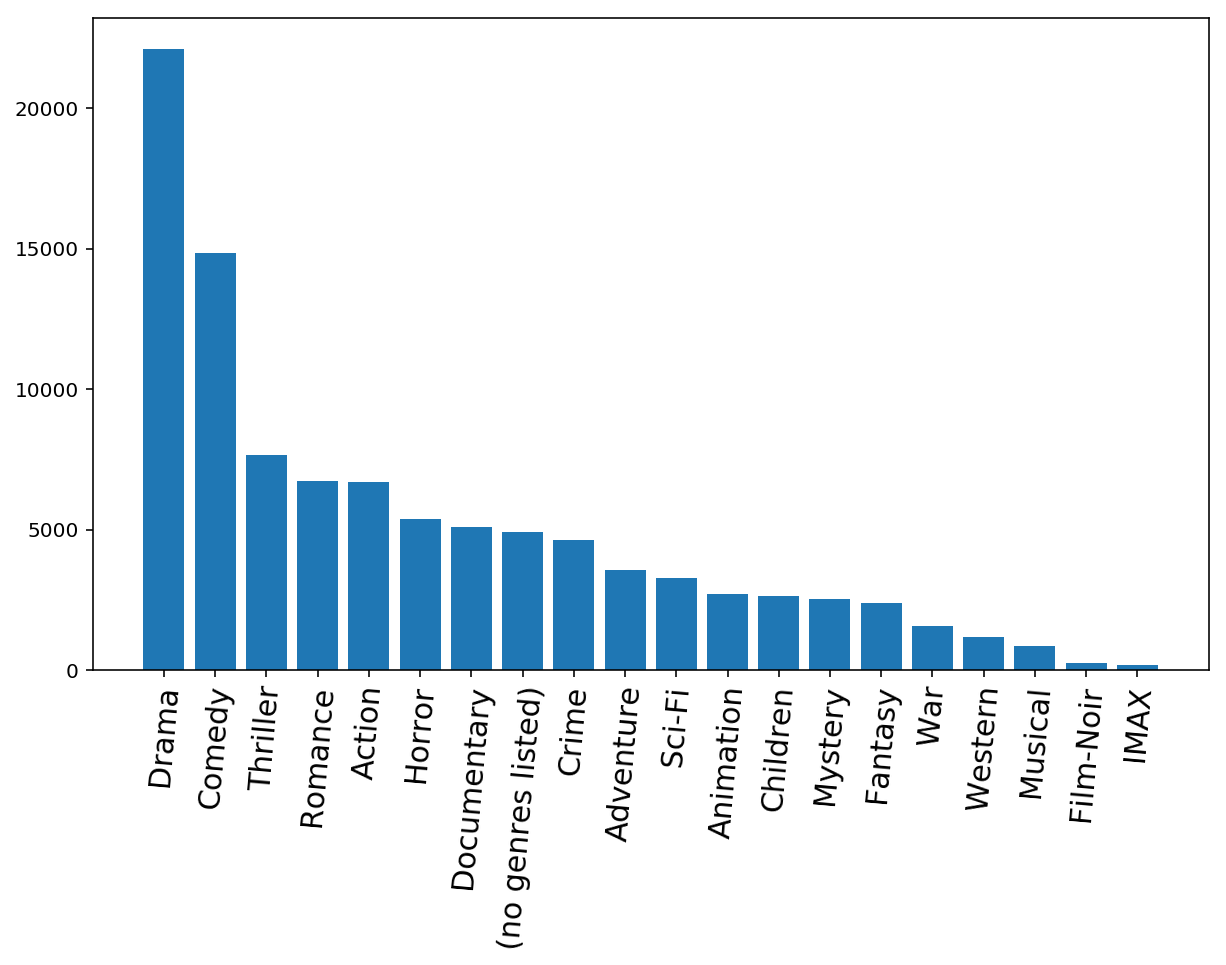

In [568]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(*zip(*gc), align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [143]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [475]:
# (movieId, title)

movieId_title = sc.textFile(MOVIES_PATH) \
                .map(lambda s: s.split(',')) \
                .filter(lambda arr: arr[0].isdigit()) \
                .filter(lambda arr: len(arr) == 3) \
                .map(lambda x: (int(x[0]), x[1]))

movieId_title.take(5)

[(1, 'Toy Story (1995)'),
 (2, 'Jumanji (1995)'),
 (3, 'Grumpier Old Men (1995)'),
 (4, 'Waiting to Exhale (1995)'),
 (5, 'Father of the Bride Part II (1995)')]

In [ ]:
# (tmdbId, movieId)

tmdbId_movieId = sc.textFile(LINKS_PATH) \
                .map(lambda s: s.split(',')) \
                .filter(lambda arr: arr[0].isdigit()) \
                .filter(lambda arr: arr[2].isdigit()) \
                .map(lambda x: (int(x[2]), int(x[0]))) 

tmdbId_movieId.take(5)

In [481]:
# (tmdbId, actor(id, name))

tmdbId_actor = tmdb \
                 .map(lambda f: json.loads(f)) \
                 .filter(lambda x: "id" in x.keys()) \
                 .filter(lambda x: "casts" in x.keys()) \
                 .keyBy(lambda x: x["id"]) \
                 .flatMapValues(lambda x: x["casts"]["cast"]) \
                 .mapValues(lambda x: (x["id"], x["name"]))

tmdbId_actor.take(5)

[(862, (31, 'Tom Hanks')),
 (862, (12898, 'Tim Allen')),
 (862, (7167, 'Don Rickles')),
 (862, (12899, 'Jim Varney')),
 (862, (12900, 'Wallace Shawn'))]

In [483]:
# (movieId, actor(id, name))

movieId_actor = tmdbId_movieId \
               .join(tmdbId_actor) \
               .map(lambda x: x[1])

movieId_actor.take(5)

[(100595, (1359360, 'Jazzy De Lisser')),
 (100595, (1190180, 'Chelsea Logan')),
 (100595, (1359361, 'Adwoa Aboah')),
 (100595, (1359362, 'Audrey Speicher')),
 (100595, (1359363, 'Jami Eaton'))]

### Tom Hanks

In [488]:
tom_hanks_movies = movieId_actor \
                   .filter(lambda x: x[1][0] == 31) \
                   .join(movieId_title) \
                   .map(lambda x: x[1][1]) \
                   .collect()

tom_hanks_movies

['Sleepless in Seattle (1993)',
 'Elvis Has Left the Building (2004)',
 'Splash (1984)',
 'Every Time We Say Goodbye (1986)',
 'Captain Phillips (2013)',
 'Toy Story of Terror (2013)',
 'Shooting War (2000)',
 'Killing Lincoln (2013)',
 'Toy Story (1995)',
 'And the Oscar Goes To... (2014)',
 'Bonfire of the Vanities (1990)',
 'Turner & Hooch (1989)',
 'Larry Crowne (2011)',
 'Magnificent Desolation: Walking on the Moon (2005)',
 'Toy Story Toons: Small Fry (2011)',
 'Punchline (1988)',
 'Toy Story 3 (2010)',
 'Sully (2016)',
 'Mazes and Monsters (1982)',
 'The Post (2017)',
 "You've Got Mail (1998)",
 'Toy Story 4 (2019)',
 'California Typewriter (2017)',
 'Radio Flyer (1992)',
 'Apollo 13 (1995)',
 'Nothing in Common (1986)',
 'Angels & Demons (2009)',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 'Extremely Loud and Incredibly Close (2011)',
 'Cars (2006)',
 'Philadelphia (1993)',
 'Toy Story Toons: Hawaiian Vacation (2011)',
 'Return with Honor (1998)',
 'Toy Story That 

### Актёры снявшиеся в наибольшем количестве фильмов

In [500]:
actor_count = movieId_actor \
              .map(lambda x: (x[1][1], 1)) \
              .reduceByKey(lambda a, b: a + b) \
              .sortBy(lambda x: x[1], ascending=False) \
              .collect()

actor_count[:10]

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 133)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [467]:
# (movieId, genre)

movieId_genre = sc.textFile(MOVIES_PATH) \
                .map(lambda s: s.split(',')) \
                .filter(lambda arr: arr[0].isdigit()) \
                .filter(lambda arr: len(arr) == 3) \
                .map(lambda x: (int(x[0]), x[2].split("|"))) \
                .flatMapValues(lambda x: x)

movieId_genre.take(5)

[(1, 'Adventure'),
 (1, 'Animation'),
 (1, 'Children'),
 (1, 'Comedy'),
 (1, 'Fantasy')]

In [351]:
# (tmdbId, movieId)

tmdbId_movieId = sc.textFile(LINKS_PATH) \
                .map(lambda s: s.split(',')) \
                .filter(lambda arr: arr[0].isdigit()) \
                .filter(lambda arr: arr[2].isdigit()) \
                .map(lambda x: (int(x[2]), int(x[0]))) 

tmdbId_movieId.take(5)

[(862, 1), (8844, 2), (15602, 3), (31357, 4), (11862, 5)]

In [364]:
# (tmdbId, year)

tmdbId_year = tmdb \
                 .map(lambda f: json.loads(f)) \
                 .filter(lambda x: "id" in x.keys()) \
                 .filter(lambda x: "release_date" in x.keys()) \
                 .filter(lambda d: d["release_date"][:4].isdigit()) \
                 .map(lambda x: (x["id"], int(x["release_date"][:4])))

tmdbId_year.take(5)

[(862, 1995), (8844, 1995), (15602, 1995), (31357, 1995), (11862, 1995)]

In [373]:
# (movieId, year)

movieId_year = tmdbId_movieId \
               .join(tmdbId_year) \
               .map(lambda x: x[1])

movieId_year.take(5)

[(139735, 2014), (147308, 2008), (174261, 1909), (8921, 1955), (923, 1941)]

In [406]:
# ((genre, year), count)

genre_year_count = movieId_genre \
                   .join(movieId_year) \
                   .map(lambda x: (x[1], 1)) \
                   .reduceByKey(lambda a, b: a + b) \
                   .sortBy(lambda kv: (kv[0][1], kv[0][0]), ascending=(True, False))\

genre_year_count.take(10)

[(('Documentary', 1874), 1),
 (('(no genres listed)', 1878), 1),
 (('Documentary', 1881), 1),
 (('(no genres listed)', 1883), 1),
 (('(no genres listed)', 1887), 1),
 (('Documentary', 1888), 4),
 (('(no genres listed)', 1890), 2),
 (('(no genres listed)', 1891), 2),
 (('Action', 1891), 1),
 (('Documentary', 1891), 4)]

In [407]:
gyc = genre_year_count.collect()

unique_pairs = dict(gyc)
unique_genres, unique_years = list(zip(*list(zip(*gyc))[0]))
unique_genres = sorted(list(np.unique(unique_genres)))
unique_years = sorted(list(np.unique(unique_years)))

In [457]:
Y = np.zeros((len(unique_genres), len(unique_years)))

for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        genre = unique_genres[i]
        year = unique_years[j]
        if (genre, year) in unique_pairs.keys():
            Y[i, j] = unique_pairs[(genre, year)]

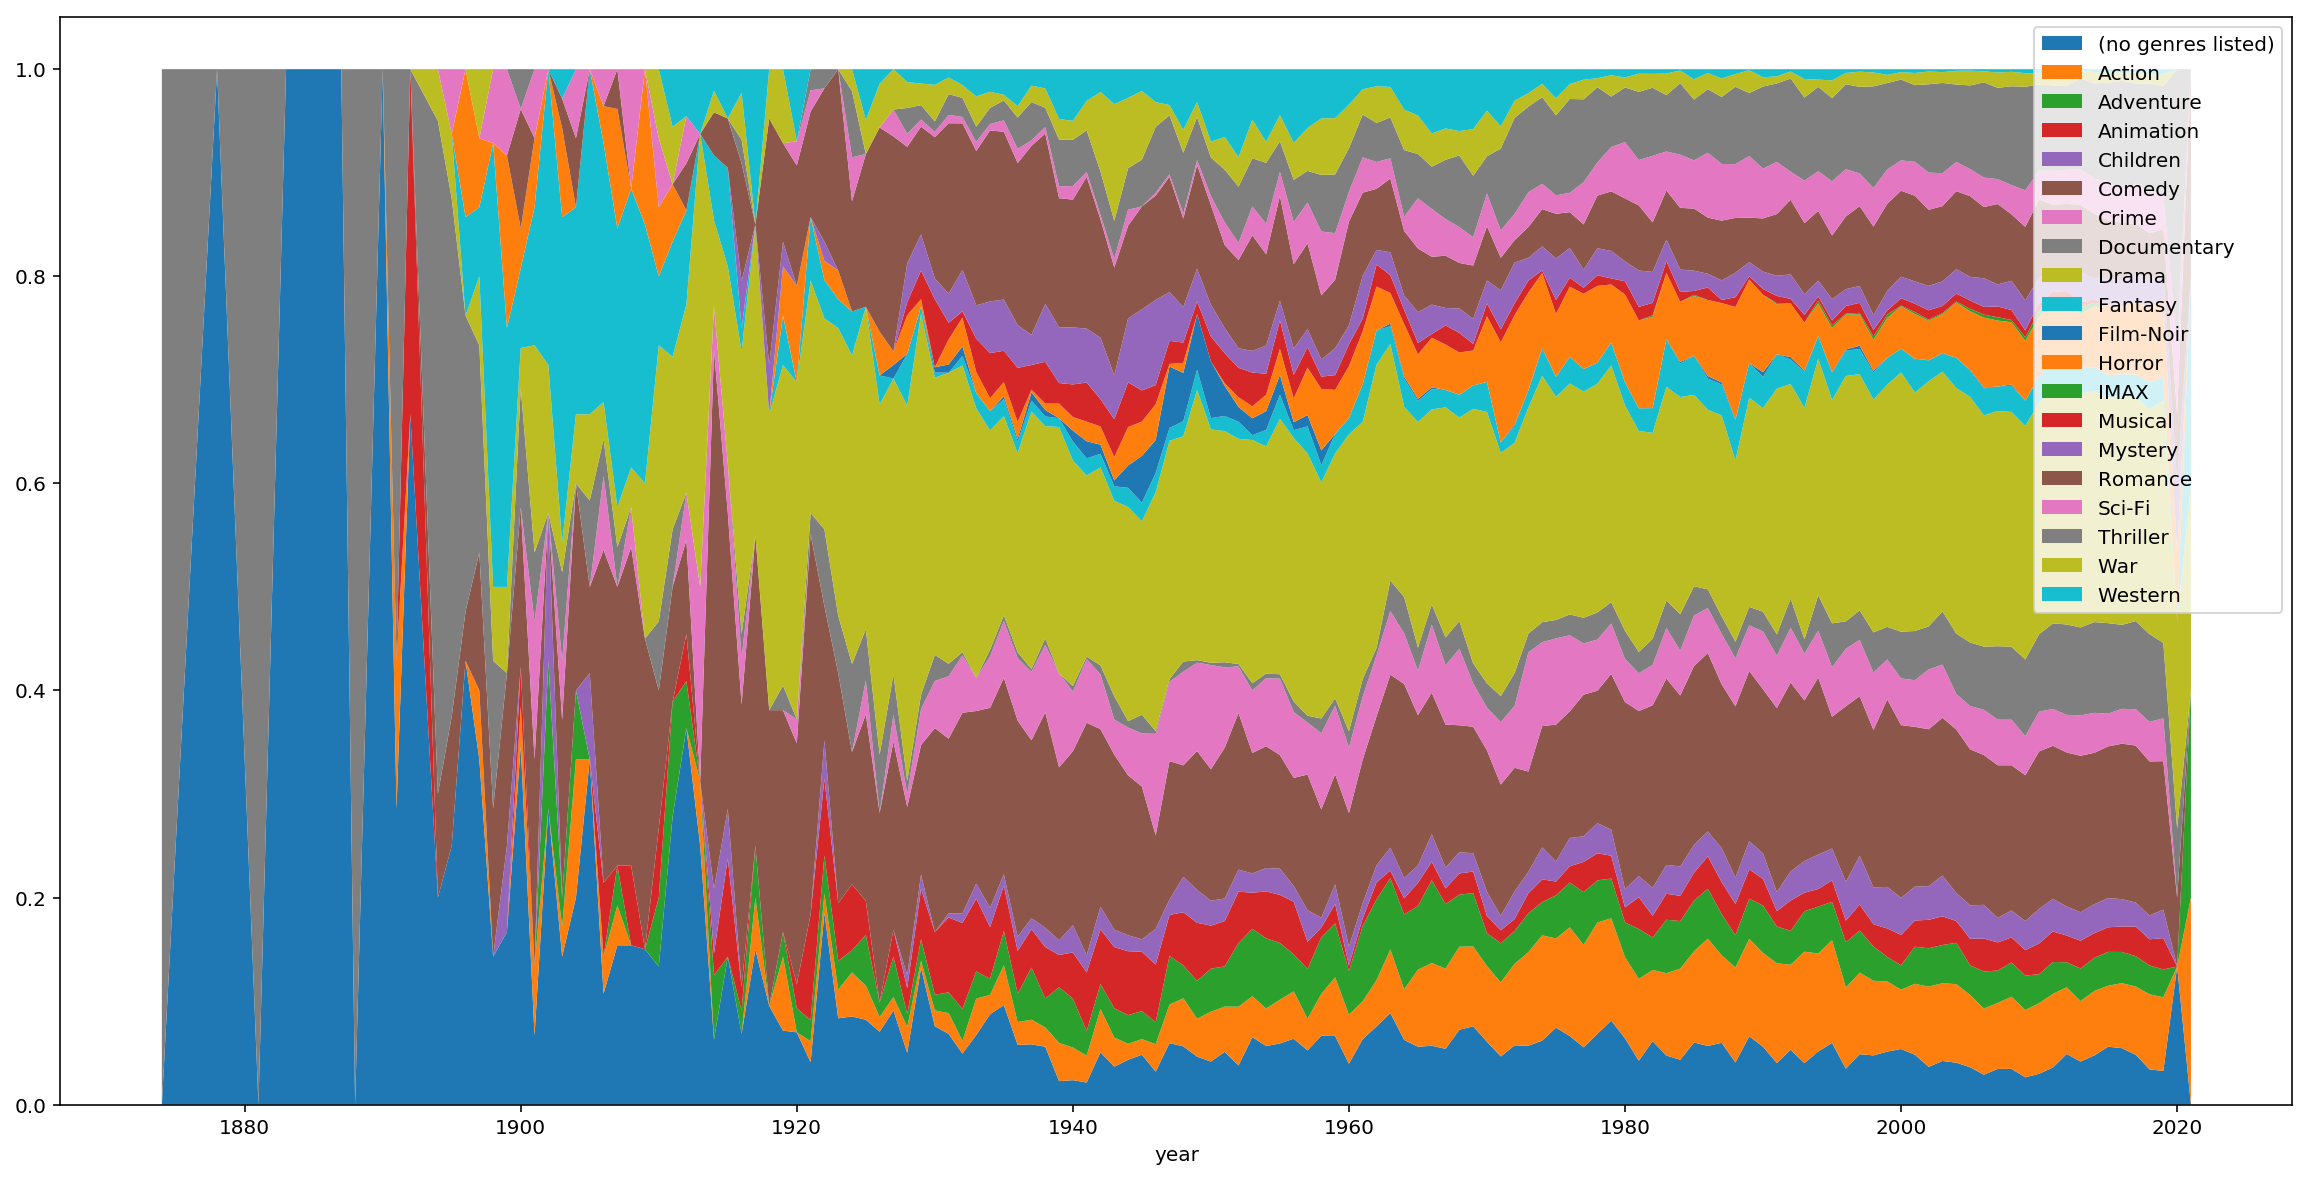

In [470]:
f, ax = plt.subplots(figsize=(20, 10))
plt.stackplot(unique_years, Y / np.sum(Y, axis=0))
plt.xlabel("year")
plt.legend(unique_genres)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [348]:
# (movieId, genre)

movieId_genre = sc.textFile(MOVIES_PATH) \
                .map(lambda s: s.split(',')) \
                .filter(lambda arr: arr[0].isdigit()) \
                .filter(lambda arr: len(arr) == 3) \
                .map(lambda x: (int(x[0]), x[2].split("|"))) \
                .flatMapValues(lambda x: x)

movieId_genre.take(5)

[(1, 'Adventure'),
 (1, 'Animation'),
 (1, 'Children'),
 (1, 'Comedy'),
 (1, 'Fantasy')]

In [315]:
# (tmdbId, movieId)

tmdbId_movieId = sc.textFile(LINKS_PATH) \
                .map(lambda s: s.split(',')) \
                .filter(lambda arr: arr[0].isdigit()) \
                .filter(lambda arr: arr[2].isdigit()) \
                .map(lambda x: (int(x[2]), int(x[0]))) 

tmdbId_movieId.take(5)

[(862, 1), (8844, 2), (15602, 3), (31357, 4), (11862, 5)]

In [319]:
# (tmdbId, (revenue, budget))

tmdbId_rev_bud = tmdb \
                 .map(lambda f: json.loads(f)) \
                 .filter(lambda x: "id" in x.keys()) \
                 .filter(lambda x: x["revenue"] > 0 and x["budget"] > 0) \
                 .map(lambda x: (x["id"], (x["revenue"], x["budget"])))

tmdbId_rev_bud.take(5)

[(862, (373554033, 30000000)),
 (8844, (262797249, 65000000)),
 (31357, (81452156, 16000000)),
 (949, (187436818, 60000000)),
 (11860, (53672080, 58000000))]

In [321]:
# (movieId, (revenue, budget))

movieId_rev_bud = tmdbId_movieId \
                 .join(tmdbId_rev_bud) \
                 .map(lambda x: x[1])

movieId_rev_bud.take(5)

[(923, (23217674, 839727)),
 (40278, (96889998, 72000000)),
 (18, (4257354, 4000000)),
 (54272, (527068851, 75000000)),
 (184741, (15500000, 7154497))]

In [340]:
# (genre, ROI)

genre_ROI = movieId_genre \
            .join(movieId_rev_bud) \
            .map(lambda x: (x[1][0], (x[1][1][0], x[1][1][1], 1))) \
            .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2])) \
            .mapValues(lambda x: (x[0] / x[2]) / (x[1] / x[2])) \
            .sortBy(lambda x: x[1], ascending=False)

genre_ROI.take(5)

[('Animation', 3.7445197085635504),
 ('Musical', 3.52277467879752),
 ('IMAX', 3.51139724270943),
 ('Documentary', 3.3843579982146563),
 ('Adventure', 3.3840624526209813)]

In [341]:
ROIs = genre_ROI.collect()

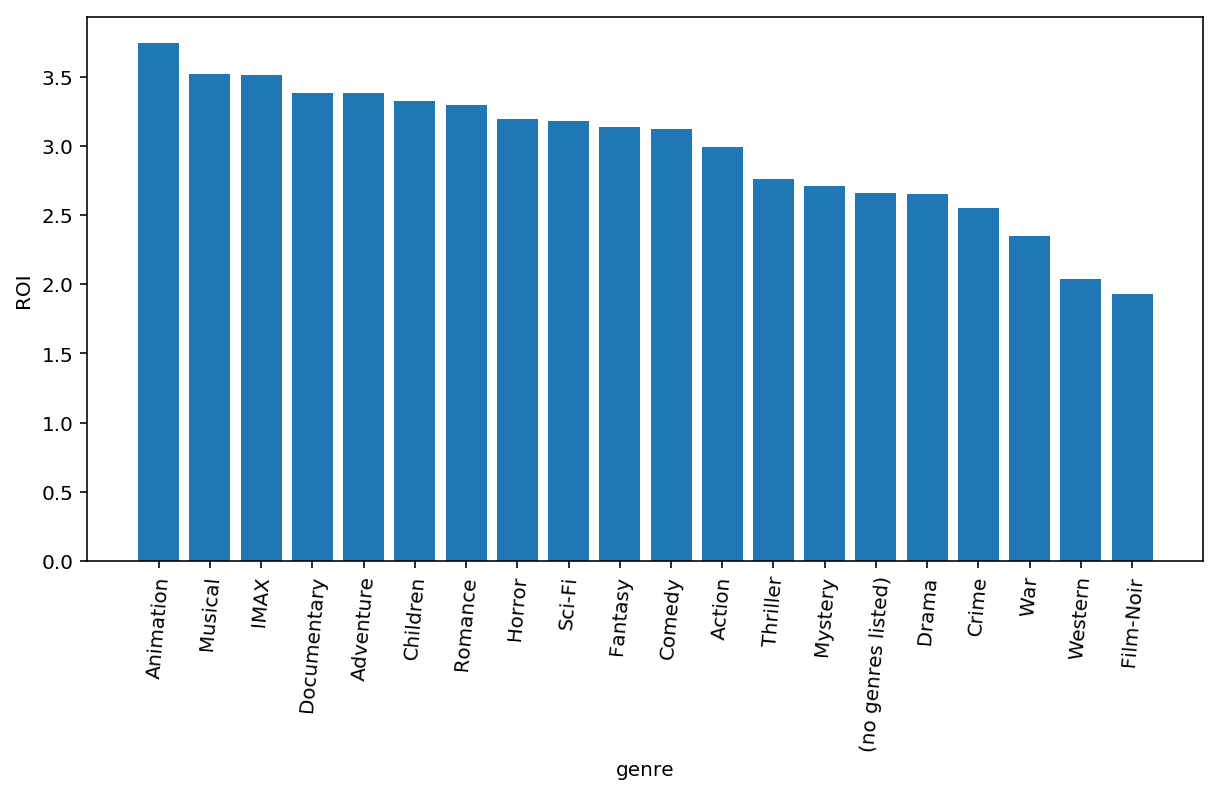

In [472]:
f, ax = plt.subplots(figsize=(10, 5))
plt.bar(*zip(*ROIs))
plt.xticks(rotation=85)
plt.xlabel("genre")
plt.ylabel("ROI")
plt.show()